In [129]:
from joblib import dump, load
import numpy as np
import cv2
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

In [246]:
#import the clustered ds swatches
hsv_knn = load('ds_h_knn_2.joblib')

# Validation steps
1. import an image made from five swatches of ds paints
2. collect the hsv and shifted HSV values
3. Drop the neutral tones
4. Cluster on K-means++ and collect the top 5 clusters
5. Match those clusters to the hsv_knn model

## Import the test image
goldfinch

In [307]:
img = cv2.imread('/Users/macbook/Box/insight_project_data/test_image/card.jpg')

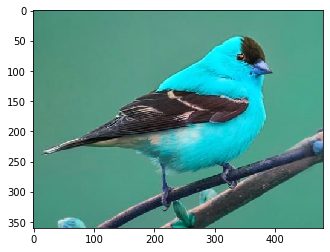

In [308]:
#don't forget it is in brg
plt.imshow(img)

In [309]:
#convert to hsv
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


In [310]:
#convert to pixels
pixels = np.float32(img_HSV.reshape(-1, 3))

In [269]:
def shift_h_remove(data, v_thresh, s_thresh):
    """Produces shifted H values for color segmentation and removed neutral tones
    Inputs: data - list of pixel H, S, V values one entry per pixel
    Outputs: H, H120, H240
    """
    shifted_colors = []
    for i in range(0,len(data)):
        H = data[i][0]
        s = data[i][1]
        v = data[i][2]
        V_thres = 255*v_thresh
        S_thres = 255*s_thresh
        if (v > V_thres and s > S_thres):
            if H >= 120:
                H120 = H - 120
            else:
                H120 = H + 60
            if H >= 60:
                H240 = H - 60
            else:
                H240 = H + 120
            shifted_colors.append([H, H120, H240, s, v])        
        else:
           pass
        
        
    return shifted_colors

In [381]:
pixels_shift = shift_h_remove(pixels, .35, .35)

In [382]:
pixels_shift[0]

[40.0, 100.0, 160.0, 126.0, 138.0]

In [12]:
len(pixels)

90000

In [8]:
len(pixels_shift)

53568

In [383]:
pixels_df = pd.DataFrame(pixels_shift, columns=['h','H120','H240','s','v'])

In [384]:
X_pixels = pixels_df[['h']]

In [385]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_pixels)
image2show = kmeans.cluster_centers_[kmeans.labels_]

In [386]:
kmeans_df = pd.DataFrame(image2show, columns=['h'])

In [387]:
kmeans_df['label'] = kmeans.labels_

In [360]:
kmeans_df.groupby('label').mean()

,h
label,
0,27.811823
1,38.255417
2,124.726307
3,9.408102
4,99.188312
5,40.621599
6,174.833333
7,33.270100
8,64.299145


In [361]:
kmeans_df.label.value_counts()

1    81510
5    30983
0    22330
7     5398
3     2345
9     1439
2     1224
4      308
8      117
6       60
Name: label, dtype: int64

In [325]:
kmeans_top = kmeans_df[(kmeans_df['label'] == 5) | (kmeans_df['label'] == 14)| (kmeans_df['label'] == 0)| (kmeans_df['label'] == 17)| (kmeans_df['label'] == 16)| (kmeans_df['label'] == 3)| (kmeans_df['label'] == 11)| (kmeans_df['label'] == 12)| (kmeans_df['label'] == 8)]

In [326]:
kmeans_top.label.value_counts()

3    71709
5    30718
0    11884
Name: label, dtype: int64

In [388]:
X = kmeans_df[['h']]

In [389]:
predict_colors = hsv_knn.predict(X)

In [390]:
colors2 = np.array(np.unique(predict_colors, return_counts=True)).T

In [391]:
colors2

array([['Cadmium Yellow Medium Hue', 16845],
       ['Green Gold', 5261],
       ['Quinacridone Gold', 828],
       ['Sap Green', 111069],
       ['Shadow Violet', 645],
       ['Ultramarine Blue', 27],
       ['Undersea Green', 3320]], dtype=object)

In [392]:
colors2df = pd.DataFrame(colors2, columns = ['name', 'count'])

In [393]:
colors2df.sort_values(by=['count'], ascending = False)

,name,count
3,Sap Green,111069
0,Cadmium Yellow Medium Hue,16845
1,Green Gold,5261
6,Undersea Green,3320
2,Quinacridone Gold,828
4,Shadow Violet,645
5,Ultramarine Blue,27


In [210]:
kmeans.cluster_centers_

array([[ 40.14481425, 100.14481425, 160.14481425],
       [132.98349835,  12.98349835,  72.98349835],
       [ 89.59223301, 149.59223301,  29.59223301],
       [ 26.71889095,  86.71889095, 146.71889095],
       [ 13.01759208,  73.01759208, 133.01759208],
       [ 38.        ,  98.        , 158.        ],
       [115.9430605 , 175.9430605 ,  55.9430605 ],
       [174.83333333,  54.83333333, 114.83333333],
       [ 33.80861792,  93.80861792, 153.80861792],
       [124.34503817,   4.34503817,  64.34503817],
       [ 67.22222222, 127.22222222,   7.22222222],
       [ 42.0921183 , 102.0921183 , 162.0921183 ],
       [ 29.64626081,  89.64626081, 149.64626081],
       [  6.50799624,  66.50799624, 126.50799624],
       [ 39.        ,  99.        , 159.        ],
       [ 21.54835997,  81.54835997, 141.54835997],
       [ 36.81518908,  96.81518908, 156.81518908],
       [ 28.        ,  88.        , 148.        ],
       [ 50.13375796, 110.13375796, 170.13375796],
       [102.56060606, 162.56060

In [13]:
colors = np.array(np.unique(kmeans.labels_, return_counts=True)).T
print(colors)

[[   0 6696]
 [   1 2085]
 [   2  889]
 [   3 2481]
 [   4 2651]
 [   5 2736]
 [   6 1636]
 [   7 2298]
 [   8 1210]
 [   9 2527]
 [  10 1786]
 [  11 6696]
 [  12 2785]
 [  13 1340]
 [  14 2831]
 [  15 2070]
 [  16 2658]
 [  17 3213]
 [  18 4045]
 [  19  935]]


In [27]:
kmeans.labels_

array([ 9,  9,  9, ..., 12,  7,  7], dtype=int32)

# Start HERE

In [327]:
hsv_knn2 = load('ds_h_knn_2.joblib')

In [337]:
predict_colors = hsv_knn2.predict(image2show)

In [338]:
predict_colors

array(['Sap Green', 'Sap Green', 'Sap Green', ..., 'Sap Green',
       'Sap Green', 'Sap Green'], dtype=object)

In [339]:
colors = np.array(np.unique(predict_colors, return_counts=True)).T

In [340]:
colors

array([['Burnt Sienna', 1996],
       ['Cadmium Yellow Medium Hue', 20610],
       ['Green Gold', 4021],
       ['Imperial Purple', 212],
       ['Phthalo Blue Green Shade', 130],
       ['Sap Green', 114311]], dtype=object)

In [341]:
predictions = pd.DataFrame(colors, columns=["name","pixels"])

In [342]:
predictions.sort_values(by=['pixels'], ascending = False)

,name,pixels
5,Sap Green,114311
1,Cadmium Yellow Medium Hue,20610
2,Green Gold,4021
0,Burnt Sienna,1996
3,Imperial Purple,212
4,Phthalo Blue Green Shade,130
